# Variational Solution of the Schroedinger's Equation in 1D with the Variational Method

This code computes by means of the variational method the ground state wavefunction (and potentially a few excited states) of an arbitrary potential well in 1D using as basis the harmonic oscillator wavefunctions, and computing the matrix elements directly as 1d integrals (no exploitation of Gaussian integrals formulae)

In [34]:
# Initialization
import numpy as np
#import scipy as sci
from scipy.integrate import quad
from scipy import linalg
from sympy import binomial
import matplotlib.pyplot as pl
import time

#Maximum number of functions to be used in the diagonalization
Nfmax=30
Nfmax=Nfmax+1
# Maximum number of eigenvalues and eigenvectors to be printed
neigmax=5

Next you have to define the potential energy. You should start from some simple one, like for instance the harmonic oscillator

In [28]:
#Potential

def v(x):
    v = 0.5 * x ** 2 + 0.7 * x ** 4-2*x**3
    return v

The following piece of code computes the Hermite functions (solutions of the Schroedinger's equation for the harmonic oscillator) by means of a recurrence formula. In particular given:
$$
\psi_0(x)=\frac{1}{\pi^{\frac{1}{4}}}\exp\left(-\frac{x^2}{2}\right)
$$                          
and
$$
\psi_1(x)=\frac{\sqrt{2}}{\pi^{\frac{1}{4}}}x\exp\left(-\frac{x^2}{2}\right)=\sqrt{2}x\psi_0(x)
$$
the other functions can be computed using:
$$
\psi_{n}(x)=\sqrt{\frac{2}{n}}\psi_{n-1}(x)-\sqrt{\frac{n-1}{n}}\psi_{n-2}(x)
$$

In [29]:
#Hermite functions

def Hermite(x,n):
    h0=np.exp(-x**2/2)*(4*np.arctan(1))**(-0.25)
    if(n==0):
        return h0
    h1=2**0.5*x*h0
    if(n==1):
        return h1
    if(n>1):
        for i in range(2,n+1):
            h2=np.sqrt(2/i)*x*h1-np.sqrt((i-1)/i)*h0
            h0=h1
            h1=h2
        return h2

Next one needs to compute the second derivative, used for the matrix element of the kinetic energy. In order to do that we need first to compute the $He_n(x)$ Hermite polynomials:

In [30]:
# Hermite polynomials

def He(x,n):
    h0=1
    if(n==0):
        return h0
    h1=x
    if(n==1):
        return h1
    if(n>1):
        for i in range(2,n+1):
            h2=x*h1-(i-1)*h0
            h0=h1
            h1=h2
        return h2

For the matrix element of the Hamiltonian you also need the second derivative of the wavefunctions, that can be computed by the following expression:
$$
\frac{d^2\psi_n(x)}{dx^2}=\sum_{k=0}^{2}\left(\begin{array}{c}2\\k\end{array}\right)(-1)^k2^{\frac{2-k}{2}}\sqrt{\frac{n!}{(n-2+k)!}}\psi_{n-2+k}(x)He_k(x)
$$
when $n-2+k\geq0$.

In [31]:
# second derivative

def d2Hermite(x,n):
    d2H = 0
    for k in range(3):
        if(n-2+k>=0):
            d2H = d2H+binomial(2,k)*(-1)**k*2**((2-k)/2)*\
                  np.sqrt(np.math.factorial(n)/np.math.factorial(n-2+k))*\
                  Hermite(x,n-2+k)*He(x,k)
    return d2H

And now we are ready for computing the matrix elements (all the functions are real!):
$$
A_{ij}=\langle \psi_i\vert \hat{H} \psi_j\rangle =\int_{-\infty}^{\infty} dx \psi_i(x)v(x)\psi_j(x)-\frac{1}{2}\int_{-\infty}^{\infty} dx \psi_i(x)\frac{d^2\psi_j(x)}{dx^2}
$$
and diagonalize the matrix to find the coefficients of the expansion on the harmonic oscillator basis. We do this for a few numbers of wavefunctions, in order to closely monitor the convergence of the eigenvalue.

In [32]:
Res=np.zeros(Nfmax)
el_tim=np.zeros(Nfmax)
NN=np.zeros(Nfmax)
vv_print=np.zeros(neigmax)
idx=0
for Nfunc in range(1,Nfmax):
    start_time=time.perf_counter()
    A=np.zeros((Nfunc,Nfunc))
    for i in range(Nfunc):
        for j in range(Nfunc):
            I1=quad(lambda x: Hermite(x,i)*v(x)*Hermite(x,j),-np.inf,np.inf)
            I2=quad(lambda x: Hermite(x,i)*d2Hermite(x,j),-np.inf,np.inf)
            A[i,j]=I1[0]-0.5*I2[0]
            #print(i,j,I1[0]-0.5*I2[0])
    vv,ww=linalg.eigh(A)
    end_time=time.perf_counter()
    el_tim[idx]=end_time-start_time
    print("Number of Functions: %3d  " % Nfunc, "G.S. eigenvalue: %8.5f" % vv[0],\
          "  Elapsed time: %5.2f" % el_tim[idx], " s")
          #,sep='\t')
    Res[idx]=vv[0]
    NN[idx]=Nfunc
    idx=idx+1

Number of Functions:   1   G.S. eigenvalue:  1.02500   Elapsed time:  0.09  s
Number of Functions:   2   G.S. eigenvalue: -0.05226   Elapsed time:  0.15  s
Number of Functions:   3   G.S. eigenvalue: -0.58471   Elapsed time:  0.45  s
Number of Functions:   4   G.S. eigenvalue: -1.03277   Elapsed time:  0.96  s
Number of Functions:   5   G.S. eigenvalue: -1.14923   Elapsed time:  1.61  s
Number of Functions:   6   G.S. eigenvalue: -1.16332   Elapsed time:  2.55  s
Number of Functions:   7   G.S. eigenvalue: -1.28050   Elapsed time:  3.68  s
Number of Functions:   8   G.S. eigenvalue: -1.33481   Elapsed time:  5.23  s
Number of Functions:   9   G.S. eigenvalue: -1.33500   Elapsed time:  7.01  s
Number of Functions:  10   G.S. eigenvalue: -1.36142   Elapsed time:  9.33  s
Number of Functions:  11   G.S. eigenvalue: -1.37611   Elapsed time: 11.88  s
Number of Functions:  12   G.S. eigenvalue: -1.37621   Elapsed time: 15.33  s
Number of Functions:  13   G.S. eigenvalue: -1.38368   Elapsed t

Now reconstruct the wavefunctions for the first few eigenstates

In [35]:
vv_print=vv[0:neigmax]
print("First ",neigmax," eigenvalues:",vv_print)
Psi=np.zeros([401,neigmax])
xxx=np.zeros(401)
vpot=np.zeros(401)
eig_plot=np.zeros((401,neigmax))
for k in range (401):
        x = 0.1*(k-200)
        xxx[k]=x
        vpot[k]=v(x)
        for l in range(neigmax):
            eig_plot[k,l]=vv_print[l]
            for n in range(Nfmax-1):
                Psi[k,l]=Psi[k,l]+ww[n,l]*Hermite(x,n)

First  5  eigenvalues: [-1.3913896   0.50907248  1.83197798  3.72947697  5.89205545]


And finally generate some plots

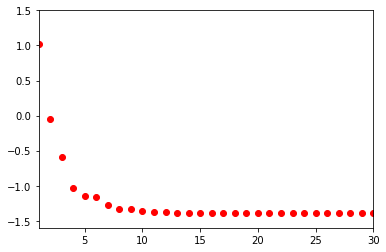

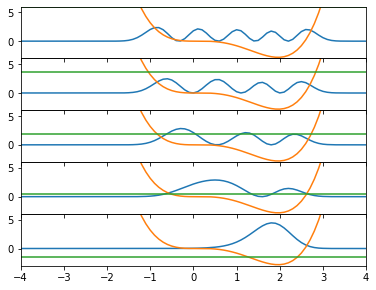

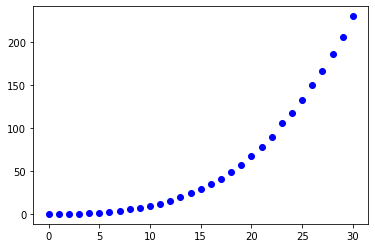

In [38]:
          
pl.figure(1)
pl.xlim([1,30])
pl.ylim([-1.6,1.5])
pl.plot(NN,Res,'ro')
fig=pl.figure(2)
#pl.xlim([-10, 10])
ax=[]
for l in range(neigmax):
    if(l==0):
        ax.append(fig.add_axes([0.1, l*0.9/neigmax, 0.8,0.9/neigmax ],
                       ylim=(-3, 6),xlim=(-4,4)))
    else:
        ax.append(fig.add_axes([0.1, l*0.9/neigmax, 0.8,0.9/neigmax ],
                       xticklabels=[], ylim=(-3, 6),xlim=(-4,4)))
    #pl.subplot(neigmax,1,l+1)
    ax[l].plot(xxx,Psi[:,l]**2*5,xxx,vpot,xxx,eig_plot[:,l])
pl.show()
pl.figure(3)
pl.plot(NN,el_tim,'bo')
pl.show()

# See PyCharm help at https://www.jetbrains.com/help/pycharm/